# Day 10

## part 1

- topographic map?? YES it's plottin' time!
- hiking trails are good if:
    - they are as long as possible
    - are monotonic and must go up by 1 per step
- trails do not move diagonally
- trailheads start trails and have height 0
- the score of a trailhead is the number of 9-height locations accessible from there
- 9-height locations can be counted by multiple trailheads

In [60]:
from copy import deepcopy
from dataclasses import dataclass
import logging

from matplotlib import pyplot as plt
import numpy as np

from advent_of_code_utils.advent_of_code_utils import (
    parse_from_file, ParseConfig as PC, markdown, plot_grid
)

log = logging.getLogger('day 10')
logging.basicConfig(level=logging.INFO)

INFO:advent_of_code_utils.py:8 items loaded from "day_10_example.txt"


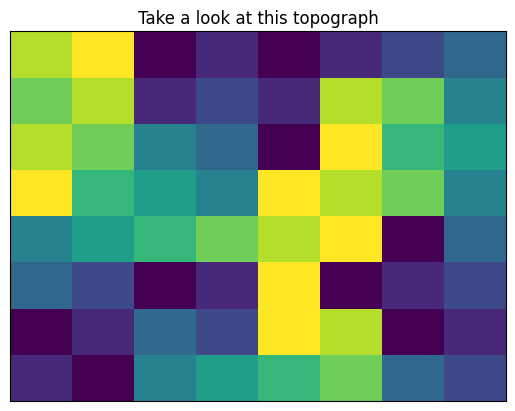

In [61]:
parser = PC('\n', PC('', int))

example = parse_from_file('day_10_example.txt', parser)

fig, ax = plt.subplots()
ax.set_title('Take a look at this topograph')
plot_grid(example, ax)

The plan is:
- create an lut of which adjacent nodes you can get to within the hiking rules
- prune any nodes from the lut which can't reach a `9`
- find all start points
- find all trails from start points
- remove duplicate trails that end at the same point but are shorter

In [62]:
# let's structure things nicely
@dataclass
class P:
    l: int
    c: int

    def __add__(self, other: 'P') -> 'P':
        return P(self.l + other.l, self.c + other.c)
    
    def __neg__(self) -> 'P':
        return P(-self.l, -self.c)

    def __sub__(self, other: 'P') -> 'P':
        return self + (-other)

    def __repr__(self) -> str:
        return f'({self.l}, {self.c})'
    
    def __hash__(self) -> int:
        return hash((self.l, self.c))
    
    def adjacent(self) -> list['P']:
        """returns adjacent loctions (does not bounds check)"""
        offsets = [P(-1, 0), P(0, 1), P(1, 0), P(0, -1)]
        return [self + offset for offset in offsets]

@dataclass
class Trail:
    path: list[P]

@dataclass
class TrailHead:
    head: P

    def find_trails(self, graph: dict[P: list[P]]) -> None:
        """populates self.trails with all possible trials"""
        self.trails = [[self.head]]
        while self.still_checking(graph):
            temp = []
            for trail in self.trails:
                point = trail[-1]
                # skip if at end of trail
                if len(graph[point]) == 0:
                    temp.append(trail)
                    continue
                for adjacent in graph[point]:
                    # skip if already been there
                    if adjacent in trail:
                        continue
                    new_trail = deepcopy(trail)
                    new_trail.append(adjacent)
                    temp.append(new_trail)
            self.trails = temp
        log.debug(f'Found {len(self.trails)} possible trails')

        # remove duplicate trail start/stops
        temp = {}
        for trail in self.trails:
            end = trail[-1]
            if end not in temp:
                temp.update({end: trail})
            # if we find a longer trail prefer that
            elif len(trail) > len(temp[end]):
                temp.update({end: trail})
            else:
                pass
        self.trails = list(temp.values())
        log.debug(f'Found {len(self.trails)} trails!')

    
    def still_checking(self, graph: dict[P: list[P]]) -> bool:
        """returns true if still checking trails"""
        ends = []
        for trail in self.trails:
            # True if more points still to check
            ends.append(len(graph[trail[-1]]) > 0)
        return any(ends)
            

def get_graph(grid: list[list[int]]) -> dict[P: list[P]]:
    """returns a dict of all the accessible trail points"""
    graph = {}
    for l_index, line in enumerate(grid):
        for c_index, char in enumerate(line):
            # if we get to a 9 that's end so just add no links and skip
            point = P(l_index, c_index)
            if char == 9:
                log.debug(f'9 at {point}')
                graph.update({point: []})
                continue
            links = []
            for p in point.adjacent():
                # bounds check
                if not (0 <= p.l < len(grid) and 0 <= p.c < len(line)):
                    continue
                # step check
                if grid[p.l][p.c] == char + 1:
                    links.append(p)
            log.debug(f'adjacent: {point} -> {links}')
            graph.update({point: links})
    log.info(f'graph with {len(graph)} nodes created')
    return graph

def prune_graph(
        graph: dict[P: list[P]], grid: list[list[int]]) -> dict[P: list[P]]:
    """prunes stunted branches from the graph"""
    temp = deepcopy(graph)
    for value in reversed(range(1, 9)):
        log.info(f'pruning {value}s')
        # prune nodes of that value with no links
        prune_list = []
        for l, line in enumerate(grid):
            for c, char in enumerate(line):
                point = P(l, c)
                if char == value and len(temp[point]) == 0:
                    temp.pop(point)
                    prune_list.append(point)
        
        # remove pruned nodes from lists of adjacent nodes
        prune_set = set(prune_list)
        for node, links in temp.items():
            for link in set(links).intersection(prune_set):
                temp[node].remove(link)

    log.info(f'{len(graph) - len(temp)} nodes pruned!')
    return temp

def find_trailheads(grid: list[list[int]]) -> list[TrailHead]:
    """returns all the trailhead locations"""
    trailheads = []
    for l_index, l in enumerate(grid):
        for c_index, c in enumerate(l):
            if c != 0:
                continue
            temp = TrailHead(P(l_index, c_index))
            log.debug(f'new trail head: {temp}')
            trailheads.append(temp)
    log.info(f'{len(trailheads)} trailheads found')
    return trailheads

log.setLevel(logging.INFO)
graph = get_graph(example)
pruned = prune_graph(graph, example)
heads = find_trailheads(example)
for head in heads:
    head.find_trails(pruned)
trail_score = sum((len(head.trails) for head in heads))
markdown(f'Total trail score is: {trail_score}')

INFO:day 10:graph with 64 nodes created
INFO:day 10:pruning 8s
INFO:day 10:pruning 7s
INFO:day 10:pruning 6s
INFO:day 10:pruning 5s
INFO:day 10:pruning 4s
INFO:day 10:pruning 3s
INFO:day 10:pruning 2s
INFO:day 10:pruning 1s
INFO:day 10:3 nodes pruned!
INFO:day 10:9 trailheads found


Total trail score is: 36

INFO:advent_of_code_utils.py:42 items loaded from "day_10.txt"


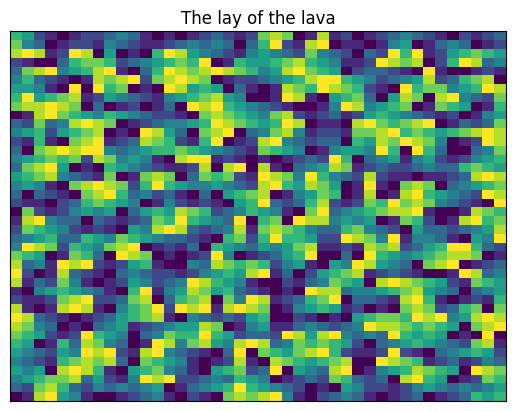

In [63]:
# ok let's try and solve!
log.setLevel(logging.INFO)
grid = parse_from_file('day_10.txt', parser)
fig, ax = plt.subplots()
ax.set_title('The lay of the lava')
plot_grid(grid, ax)


INFO:day 10:graph with 1764 nodes created
INFO:day 10:pruning 8s
INFO:day 10:pruning 7s
INFO:day 10:pruning 6s
INFO:day 10:pruning 5s
INFO:day 10:pruning 4s
INFO:day 10:pruning 3s
INFO:day 10:pruning 2s
INFO:day 10:pruning 1s
INFO:day 10:114 nodes pruned!


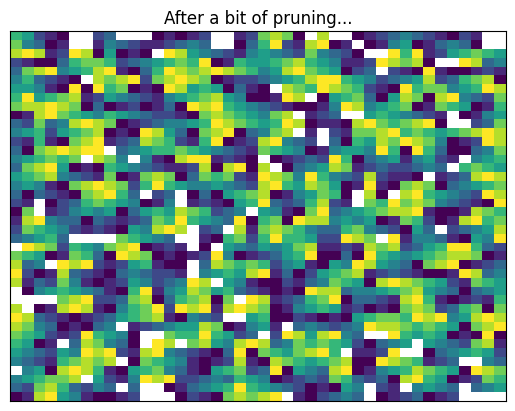

In [64]:
graph = get_graph(grid)
pruned = prune_graph(graph, grid)

def plot_graph(
        graph: dict[P: list[P]], grid: list[list[int]], ax: plt.Axes) -> None:
    """renders a graph look up table"""
    temp = [[np.nan]*len(line) for line in grid]

    for point in graph:
        temp[point.l][point.c] = grid[point.l][point.c]
    
    plot_grid(temp, ax)
    

fig, ax = plt.subplots()
ax.set_title('After a bit of pruning...')
plot_graph(pruned, grid, ax)

In [65]:
heads = find_trailheads(grid)
for head in heads:
    head.find_trails(pruned)
trail_score = sum((len(head.trails) for head in heads))
markdown(f'Total trail score is: {trail_score}')

INFO:day 10:194 trailheads found


Total trail score is: 514

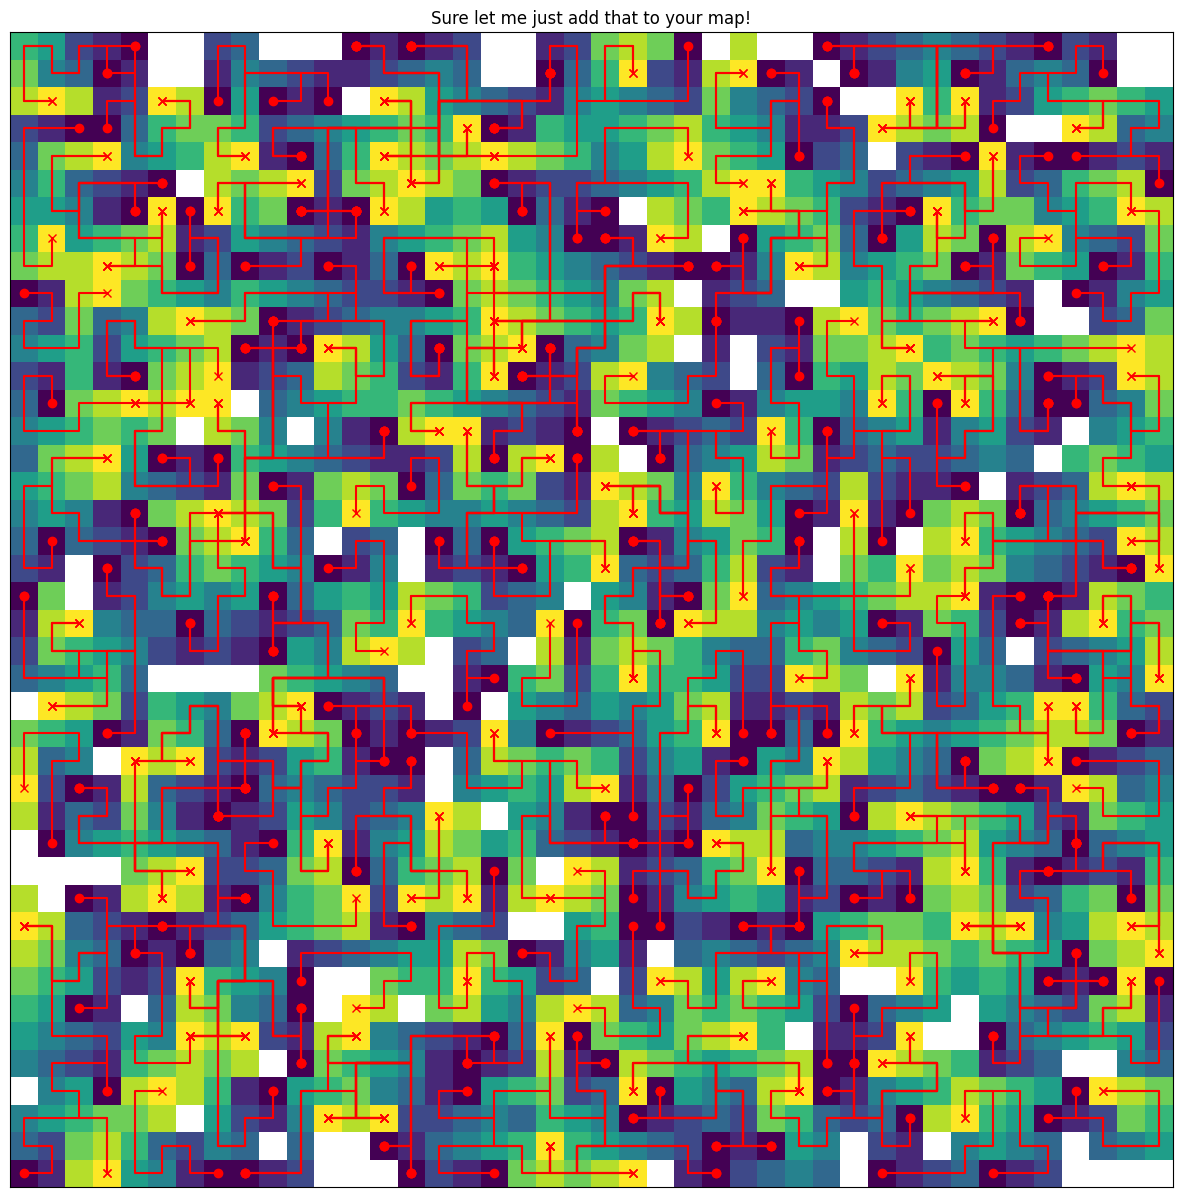

In [67]:
def plot_trail(trail: Trail, grid: list[list[int]], ax: plt.Axes) -> None:
    temp = [P(len(grid) - 1 - point.l + 0.5, point.c + 0.5) for point in trail]
    y_vals = [p.l for p in temp]
    x_vals = [p.c for p in temp]
    ax.plot(x_vals, y_vals, color='r')
    ax.plot(x_vals[0], y_vals[0], marker='o', color='r')
    ax.plot(x_vals[-1], y_vals[-1], marker='x', color='r')

fig, ax = plt.subplots()
fig.set_size_inches(15, 15)  # Nice and big!
ax.set_title('Sure let me just add that to your map!')
plot_graph(pruned, grid, ax)
for head in heads:
    for trail in head.trails:
        plot_trail(trail, grid, ax)